## Imports

In [2]:
import pandas as pd
import numpy as np
import os
import warnings

from tqdm import tqdm
import zlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.ticker import PercentFormatter

### Load Data For EDA
There are 4 files found in the data directory:

- IdLookupTable - TBD
- SampleSubmission - TBD
- test - TBD
- training - TBD 

We must load this data in order to perform EDA.  


In [4]:

#https://realpython.com/python-zip-function/#:~:text=%20Using%20the%20Python%20zip%20()%20Function%20for,zip%20()%20function%20works%20differently%20in...%20More

df, git_path = {}, 'data/'
for file_name, file_ref, n, t in zip(['IdLookupTable.csv', 'SampleSubmission.csv', 'test.csv', 'training.csv'],
                        ['id_lookup', 'sample_submission', 'test', 'train'],
                        [['row_id', 'image_id', 'feature_name', 'location'],
                            ['row_id', 'location'],
                            ['image_id', 'image'],
                            ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 
                            'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 
                            'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 
                            'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 
                            'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'image']],
                            [{'row_id':'uint16', 'image_id':'uint16', 'location':'float32'},
                            {'row_id':'uint16', 'location':'float32'},
                            {'image_id':'uint16', 'image':'object'},
                            {'left_eye_center_x':'float32', 'left_eye_center_y':'float32', 'right_eye_center_x':'float32', 'right_eye_center_y':'float32', 
                            'left_eye_inner_corner_x':'float32', 'left_eye_inner_corner_y':'float32', 'left_eye_outer_corner_x':'float32', 'left_eye_outer_corner_y':'float32', 
                            'right_eye_inner_corner_x':'float32', 'right_eye_inner_corner_y':'float32', 'right_eye_outer_corner_x':'float32', 'right_eye_outer_corner_y':'float32', 
                            'left_eyebrow_inner_end_x':'float32', 'left_eyebrow_inner_end_y':'float32', 'left_eyebrow_outer_end_x':'float32', 'left_eyebrow_outer_end_y':'float32', 
                            'right_eyebrow_inner_end_x':'float32', 'right_eyebrow_inner_end_y':'float32', 'right_eyebrow_outer_end_x':'float32', 'right_eyebrow_outer_end_y':'float32', 
                            'nose_tip_x':'float32', 'nose_tip_y':'float32', 'mouth_left_corner_x':'float32', 'mouth_left_corner_y':'float32', 'mouth_right_corner_x':'float32', 
                            'mouth_right_corner_y':'float32', 'mouth_center_top_lip_x':'float32', 'mouth_center_top_lip_y':'float32', 'mouth_center_bottom_lip_x':'float32', 
                            'mouth_center_bottom_lip_y':'float32', 'image':'object'}]):
    print("Begin file '%s' load" % "".join( (git_path, file_name)))
    print(file_ref)
    df[file_ref] = pd.read_csv("".join( (git_path,file_name) ), names = n, dtype = t, skiprows = 1)
    #If the file contains an image column like in the case of test.csv process those images now. 
    if "image" in df[file_ref]:
        print("\tProcessing %d images..." % df[file_ref].shape[0])
        #Get the row with the image data and store it in the dataframe 
        df[file_ref]['image'] = df[file_ref]["image"].map(lambda x: np.array(list(map(int, x.split(" ")))))
    print("\tEnd File load with shape:", df[file_ref].shape, "\n")

print("Data load complete")

Begin file 'data/IdLookupTable.csv' load
id_lookup
	End File load with shape: (27124, 4) 

Begin file 'data/SampleSubmission.csv' load
sample_submission
	End File load with shape: (27124, 2) 

Begin file 'data/test.csv' load
test
	Processing 1783 images...
	End File load with shape: (1783, 2) 

Begin file 'data/training.csv' load
train
	Processing 7049 images...
	End File load with shape: (7049, 31) 

Data load complete


In [5]:
train, test = df['train'][['image']], df['test'][['image']]


In [6]:
# Check for duplicate train images
train = df['train'].reset_index().copy()
#Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
train['check_sum'] = train.image.map(lambda x: zlib.adler32(x))

#Create a DF to store duplicates, grouping them together and sorting them
train_duplicates = pd.DataFrame(train.groupby(by='check_sum').index.count().sort_values()).reset_index()
#Add a column to keep track of how many of each check sum there are
train_duplicates.columns = ['check_sum', 'number_found']
#Keep the ones where we have > 1 number_found
train_duplicates = train_duplicates[(train_duplicates.number_found > 1)]
#Now do a left outer join back to train_duplicates.  This should only keep the duplicates 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#:~:text=merge%20is%20a%20function%20in%20the%20pandas%20namespace,,the%20index-on-index%20(by%20default)%20and%20column%20(s)-on-index%20join.
train_duplicates = pd.merge(train_duplicates, train[['index', 'check_sum']],  how = 'left', on=['check_sum']).sort_values(by=['number_found', 'check_sum'], ascending = False)


#Now do the same for test:
# Check for duplicate train images
test = df['test'].reset_index().copy()
#Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
test['check_sum'] = test.image.map(lambda x: zlib.adler32(x))
#Create a DF to store duplicates, grouping them together and sorting them
test_duplicates = pd.DataFrame(test.groupby(by='check_sum').index.count().sort_values()).reset_index()
#Add a column to keep track of how many of each check sum there are
test_duplicates.columns = ['check_sum', 'number_found']
#Keep the ones where we have > 1 number_found
test_duplicates = test_duplicates[(test_duplicates.number_found > 1)]
#Now do a left outer join back to train_duplicates.  This should only keep the duplicates 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#:~:text=merge%20is%20a%20function%20in%20the%20pandas%20namespace,,the%20index-on-index%20(by%20default)%20and%20column%20(s)-on-index%20join.
test_duplicates = pd.merge(test_duplicates, test[['index', 'check_sum']],  how = 'left', on=['check_sum']).sort_values(by=['number_found', 'check_sum'], ascending = False)

print("EDA on duplicate data in train and test datasets: ")
print("The train dataset has %d unique images and %d duplicate images" % (len(np.unique(train_duplicates.check_sum)), len(train_duplicates)))
print("The test dataset has %d unique images and %d duplicate images" % (len(np.unique(test_duplicates.check_sum)),len(test_duplicates)))

#Clean up:
#We don't really need the check_sum column anymore...so drop it
train.drop(columns=['check_sum'], inplace=True)
test.drop(columns=['check_sum'], inplace=True)

EDA on duplicate data in train and test datasets: 
The train dataset has 543 unique images and 1098 duplicate images
The test dataset has 29 unique images and 60 duplicate images


[3113 3740 4296 4873 5970 2490 3741 5414 5969 6583 2681 3317 3936 3937
 2678 3935 5066 6149 2774 4574 6243 2773 5141 6858 3665 4801 2316 7013
 4400 6665 6306 6924 4398 4968 3625]


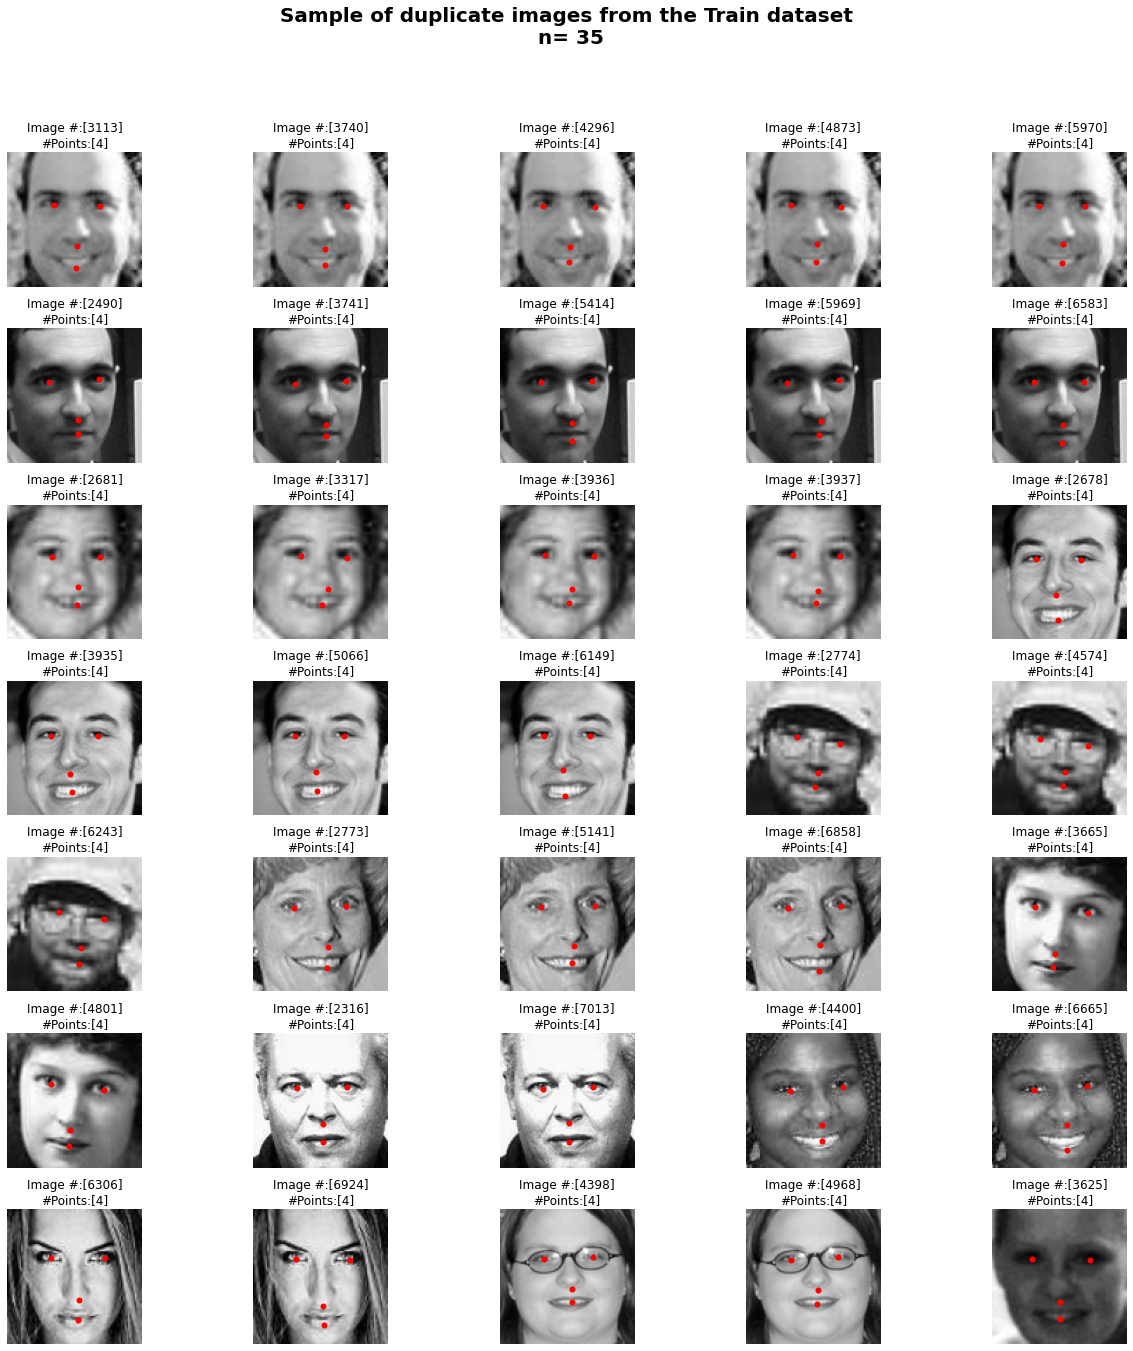

In [9]:

## TRAIN 
# Let's view some of these duplicated train images
fig = plt.figure(figsize=(18,18))
fig.suptitle('Sample of duplicate images from the Train dataset\n n= 35', size = 20,  y = 1.04, weight = 'bold')
#Get the point coordinates for example: mouth_center_top_lip_x
coordinates = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]
#print(coordinates)
#Get the top 35 duplicate images
idx = train_duplicates.head(35)['index'].values
#For testing, these are the duplicate ID's
print(idx)

match_pts = pd.DataFrame(columns =['Points_Found', 'Count'])

#Loop through and plot each of the 35 images.  
for i, idx in enumerate(idx):
    plt.subplot(7,5,i+1)
    img = train[(train['index'] == idx)].image.values[0].reshape(96,96)
    #These are the points that have been identified on the images
    points = train[(train['index'] == idx)][coordinates].values[0]
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    matching_pts = 0

    for pts in range(0, 30, 2):
        x_point, y_point = (points[pts], points[pts+1])
        if not (np.isnan(x_point)) and not (np.isnan(y_point)):
            matching_pts += 1
            #Add the point to the plot
            plt.plot(x_point, y_point, 'o', color = "red", markersize = 5)

    plt.title("Image #:[%d]\n#Points:[%d]" % (idx, matching_pts))
    if matching_pts in match_pts["Points_Found"].values:
            match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] = match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] + 1
    else:
        match_pts = match_pts.append({'Points_Found':matching_pts,'Count': 1},ignore_index=True)


plt.tight_layout()
plt.show()

In [11]:
idx = train_duplicates['index'].values
#For testing, these are the duplicate ID's
print(idx)
match_pts = pd.DataFrame(columns =['Points_Found', 'Count'])

#Loop through and plot each of the 35 images.  
for i, idx in enumerate(idx):
    img = train[(train['index'] == idx)].image.values[0].reshape(96,96)
    #These are the points that have been identified on the images
    points = train[(train['index'] == idx)][coordinates].values[0]
    matching_pts = 0

    for pts in range(0, 30, 2):
        x_point, y_point = (points[pts], points[pts+1])
        if not (np.isnan(x_point)) and not (np.isnan(y_point)):
            matching_pts += 1
            
    if matching_pts in match_pts["Points_Found"].values:
            match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] = match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] + 1
            
    else:
        match_pts = match_pts.append({'Points_Found': matching_pts,'Count': 1},ignore_index=True)
        
print(match_pts)




[3113 3740 4296 ... 3732 2451 4266]
  Points_Found Count
0            4  1096
1           15     1
2           13     1


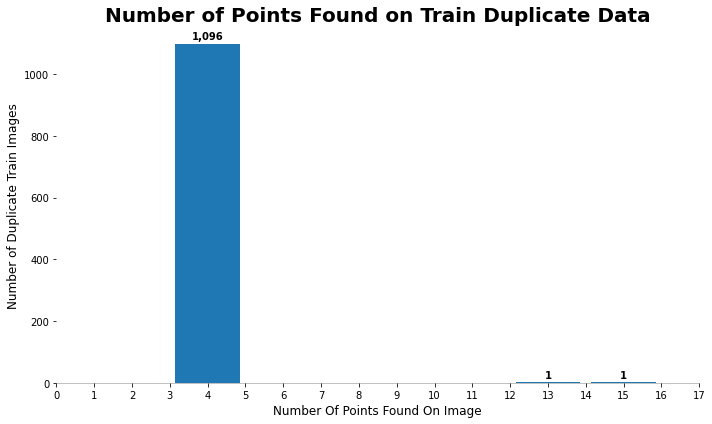

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.set_title('Number of Points Found on Train Duplicate Data', fontsize = 20, fontweight = 'bold')
ax.bar(match_pts.Points_Found, match_pts.Count, width = 1.7)
ax.set_xticks(range(0,18,1))
for i, r in match_pts.iterrows():
    plt.text(r.Points_Found, r.Count + 25, format(r.Count, ",d"), 
        horizontalalignment = 'center', verticalalignment = 'center', fontweight ='bold')
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.0)
ax.set_xlabel("Number Of Points Found On Image", fontsize = 12, horizontalalignment='center')
ax.set_ylabel("Number of Duplicate Train Images", fontsize = 12, horizontalalignment='center')

plt.tight_layout()
plt.show()